In [79]:
import  pandas as pd
import re
from collections import Counter
from math import ceil
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
import seaborn as sns

import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

import joblib

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ankur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# read csv file
textData = pd.read_csv("Emotions_training.csv")

# showing data 
textData.head(5)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [3]:
textData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB


# Data Pre-processing

Text column fits to be a **string** datatype which will enable us to perform string operations if needed in future for any analysis.

In [4]:
string_colms = {'text':'string'}
textData = textData.astype(string_colms)
textData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  string
 1   label   16000 non-null  int64 
dtypes: int64(1), string(1)
memory usage: 250.1 KB


In [5]:
textData.describe()

,label
count,16000.000000
mean,1.565937
std,1.501430
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,5.000000


As we see maximum integer value in **label** colume is **5** so **int8** datatype will be enough.

In [6]:
#converting datatype for the int column
textData['label'] = textData['label'].astype('int8')
textData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  string
 1   label   16000 non-null  int8  
dtypes: int8(1), string(1)
memory usage: 140.8 KB


So,now datatype is fixed.

Moving further, there are certain required pre-rpocessing asked to be done in this project. These are as mentioned below : 
- Covert to Lower Case
- Remove links
- Remove next lines (\n)
- Remove Words containing numbers
- Remove Extra spaces
- Remove Special characters

While perfoming above data-perprocessing the impact was not clearly visible as we did not know what rows are getting refactored. So,firstly let's check upon the impact of performing these on the rows of dataset we have.

In [7]:
# Find if upper case exists to be converted to lower case
rowsWithCapitalLetters = textData[textData['text'].str.islower() == False].shape[0]

# Find rows with links to be removed
rowsWithLinks = textData[textData['text'].str.contains(r'https?://[^\s]+')].shape[0]

# Find rows with newlines to be removed
rowsWithNewLine = textData[textData['text'].str.contains('\n')].shape[0]

# Find rows with special characters to be removed
def has_special_chars(text):
    for char in text:
        if not char.isalnum() and char not in [' ']: # It can also be new line but its zero as well :)
            return True
    return False

rowsWithSpChar = textData[textData['text'].apply(has_special_chars)].shape[0]

# Find rows with alphanumeric characters to be removed
def has_alnum(text):
    for char in text:
        if char.isnumeric():
            return True
    return False

rowsWithNum = textData[textData['text'].apply(has_alnum)].shape[0]

# Find rows with extra spaces to be removed
def has_extra_spaces(text):
    return '  ' in text

rowsWithExSpc = textData[textData['text'].apply(has_extra_spaces)].shape[0]

print(rowsWithCapitalLetters, 
      rowsWithLinks, 
      rowsWithNewLine, 
      rowsWithSpChar, 
      rowsWithNum, 
      rowsWithExSpc)

0 0 0 0 0 0


For the checks mentioned for the pre-processing, all the impacted rows were extracted into their respective dataframes and looked upon the count of rows impacted. Surprisingly, none of the rows had anything that would be altered even if these pre-processing steps were performed.
Therefore it is concluded that these pre-processing steps would have no change on the dataset.

However, while performing these, it was found that the text data has random words, weird songs, html tags, etc inserted to many of the sentences in text column making our data noisy. Below is one of the example :

In [8]:
# Finding occurance of random word in dataset
randomWords = textData[textData['text'].str.contains('http')] #https, href, a href http, www, etc
print(randomWords.shape)
randomWords.head(5)

(199, 2)


,text,label
125,i feel they are pretty safe on my blog img src...,1
323,i stopped feeling so exhausted a href http pro...,0
462,i feel so dazed a href http twitter,5
866,i feel unwelcome at work sometimes and think p...,0
967,i a href http feeling groggy,0


So, an attempt is being made to find and get rid of as much noise as possible by removing it.

In [9]:
# Define the substrings to remove
remove_strings = [' a href http ', ' http ', ' https ', ' www ', ' href ', ' src ', ' img ', ' s ']

# Iterate through each substring and remove it from the 'text' column in the main DataFrame
for substring in remove_strings:
    textData['text'] = textData['text'].str.replace(substring, ' ')

In [10]:
# Checking if it is removed for one as example
randomWords = textData[textData['text'].str.contains('http')] #http, href, a href http, www, etc
print(randomWords.shape)
randomWords.head(5)

(12, 2)


,text,label
1531,i definitely feel like hot stuff strutting dow...,2
2263,i do not know how to feel my hearts aching sad...,0
3170,i am feeling so festive right now and not just...,1
3231,im feeling my loving heart is all yours for th...,2
4986,im feeling determined to face facts have a gan...,1


#### Question : 
Above is not scalable way. How can we deal with such a scenerio efficiently ? 

In [11]:
# removing stop words
stop_words = set(stopwords.words('english'))
textData['text'] = textData['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
textData['text'] = textData['text'].astype('string') # as above operation changes it to object

In [12]:
# stemming
stemmer = PorterStemmer()
textData['text'] = textData['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))


In [13]:
#lemmatization
lemmatizer = WordNetLemmatizer()
textData['text'] = textData['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
textData['text'] = textData['text'].astype('string') # as above operation changes it to object

In [14]:
textData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  string
 1   label   16000 non-null  int8  
dtypes: int8(1), string(1)
memory usage: 140.8 KB


So we have completed with data-preprocessing.As we can see that before data-preprocessing the memory usage was **250.1+ KB** and after data-preprocessing the memory usage is **140.8 KB** it clearly show that memory usage is **reduced**.

### Class Distribution

Another important thing to make sure before feeding our data into the model is the class distribution of the data. In our case where the expected class are divided into six outcomes, 0 to 5, an equal class distribution can be considered ideal.

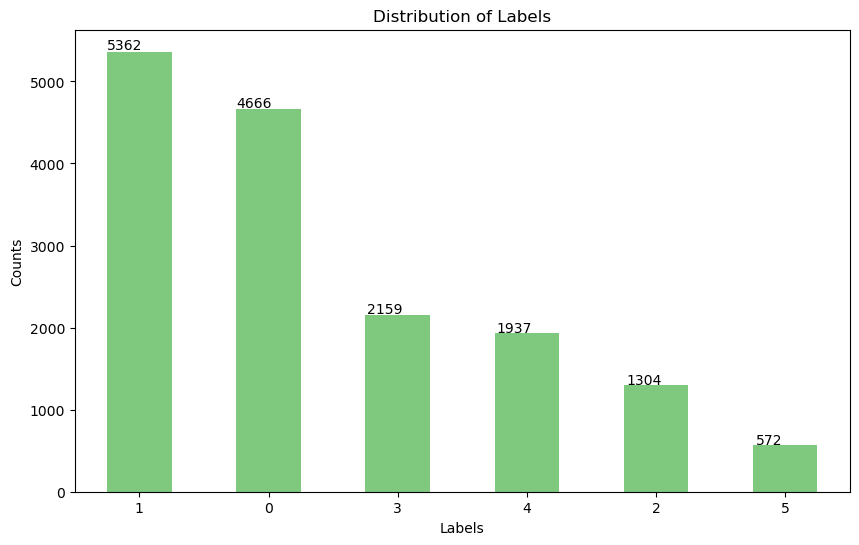

In [97]:
label_counts = textData['label'].value_counts()
plt.figure(figsize=(10, 6))
ax = label_counts.plot(kind='bar', colormap='Accent')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(rotation=0)

# Adding the counts on top of the bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

The dataset has an **imbalanced class distribution**. Classes 1 and 0 have significantly more samples than classes 3, 4, 2, and especially 5. This imbalance can affect the performance of the classification models, as they may become biased towards the more frequent classes.

#### Implications and Actions:

**Evaluation Metrics**: Instead of relying solely on **_accuracy_**, use evaluation metrics that account for class imbalance, such as **_precision_**, **_recall_**, **_F1-score_**, and the **_confusion matrix_**. These metrics will provide a more comprehensive understanding of model performance across all classes.

##### Resampling Techniques:

**Oversampling**: Increase the number of samples in the minority classes (e.g., using SMOTE - Synthetic Minority Over-sampling Technique).

**Undersampling**: Decrease the number of samples in the majority classes.

**Hybrid Methods**: Combine both oversampling and undersampling to balance the dataset.

**Class Weight Adjustment**: When training machine learning models, especially in algorithms like Logistic Regression and SVM, you can adjust the class weights to give more importance to the minority classes. This can be done using the class_weight parameter.

### Splitting Data

As we are building models, we will be dividing our data into 3 sections viz training, testing & validation. 

In [16]:
# Split into 70% training and 30% remaining
X_train, X_temp, y_train, y_temp = train_test_split(textData['text'], textData['label'], test_size=0.3, random_state=42)

# Split the remaining 30% into 20% testing and 10% validation
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# Verify the sizes
print(f'Training set: {len(X_train)} samples')
print(f'Testing set: {len(X_test)} samples')
print(f'Validation set: {len(X_val)} samples')

Training set: 11200 samples
Testing set: 3216 samples
Validation set: 1584 samples


The entire data is divided into **70% training, 20% Testing & 10% Validation**. 

### Vectorization Of Data

- Vectorization is essential for text classification tasks because machine learning algorithms typically require numerical input data. 
- Text data, being categorical and unstructured, needs to be converted into a numerical format that algorithms can process effectively. 
- Vectorization transforms text into numerical features, allowing machine learning models to learn patterns and make predictions based on the text's content.

We will be using **TF-IDF** technique of vectorization. TF-IDF, short for Term Frequency–Inverse Document Frequency, is a numerical statistic that is intended to reflect how important a word is to a document, in a collection or Corpus(Paragraph) as its value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general

In [17]:
# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_val_tfidf = vectorizer.transform(X_val)

### Resampling Data

Further, as we have class imbalance, we will perform resampling of our data and keep it ready to be used for different algorithms later. Based on the dataset, we will use a hybrid resampling technique consisting **SMOTE** & **TomekLinks**.

**SMOTE** : It will generate synthetic samples for the minority class to balance the dataset.
**Tomek Links** : These are pairs of very close instances, but from different classes. Removing these pairs helps in cleaning the class boundaries.

In [18]:
# Applying SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)

Counter({4: 3781, 0: 3781, 1: 3781, 2: 3781, 5: 3781, 3: 3781})


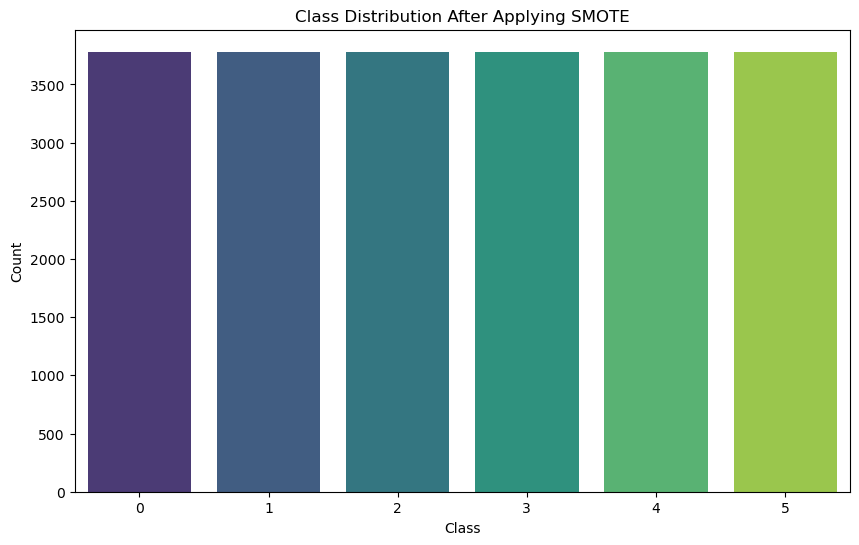

In [19]:
# Visualizing Dataset
from collections import Counter

# Count the number of instances for each class
class_distribution = Counter(y_resampled)
print(class_distribution)

# Create a DataFrame for easy plotting
class_dist_df = pd.DataFrame.from_dict(class_distribution, orient='index').reset_index()
class_dist_df.columns = ['Class', 'Count']

# Plot the class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Count', data=class_dist_df, palette='viridis')
plt.title('Class Distribution After Applying SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [20]:
# Applying Tomek Links
tomek = TomekLinks()
X_resampled, y_resampled = tomek.fit_resample(X_resampled, y_resampled)

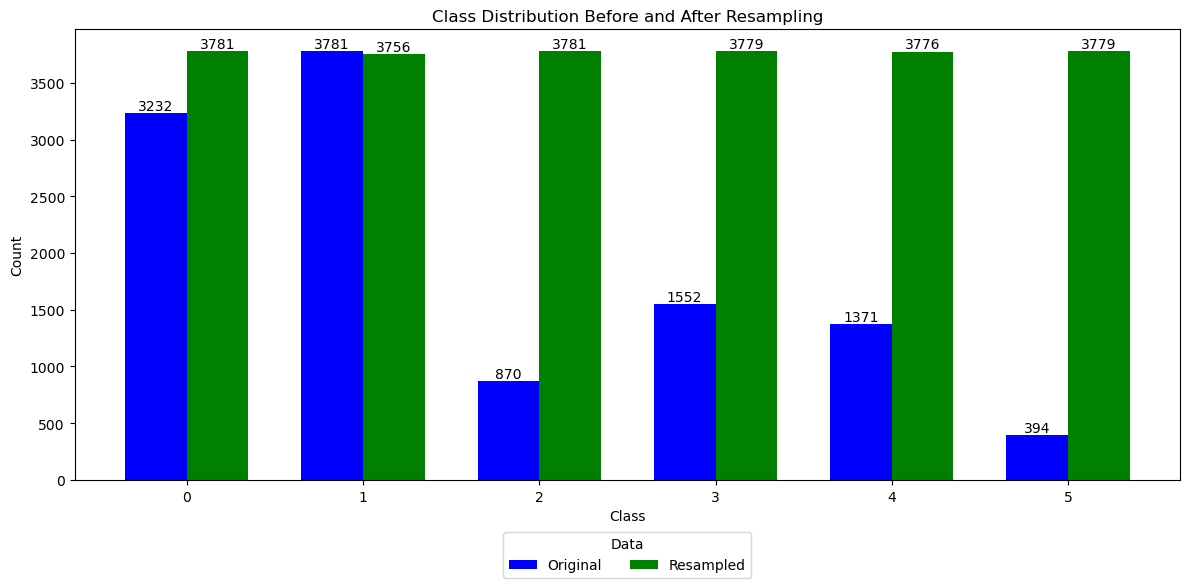

In [99]:
# Visualizing training data difference

# Count the number of instances for each class before and after resampling
class_distribution_original = Counter(y_train)
class_distribution_resampled = Counter(y_resampled)

# Create DataFrame for plotting
original_dist_df = pd.DataFrame.from_dict(class_distribution_original, orient='index').reset_index()
original_dist_df.columns = ['Class', 'Count_Original']

resampled_dist_df = pd.DataFrame.from_dict(class_distribution_resampled, orient='index').reset_index()
resampled_dist_df.columns = ['Class', 'Count_Resampled']

# Merge the dataframes for plotting
merged_df = pd.merge(original_dist_df, resampled_dist_df, on='Class')

# Plotting
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = merged_df['Class']

bar1 = plt.bar(index, merged_df['Count_Original'], bar_width, label='Original', color='b')
bar2 = plt.bar(index + bar_width, merged_df['Count_Resampled'], bar_width, label='Resampled', color='g')

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution Before and After Resampling')
plt.xticks(index + bar_width / 2, merged_df['Class'])
plt.legend(title='Data', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)

# Add counts on each bar
for bar in bar1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')
for bar in bar2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Modeling

Hereafter, we will be using different classification algorithms to create models. We have a variety of algorithms that would be best suited for out datset. The performance of these models will be evaluated based on metrics like accuracy, precision, recall & F1-score.  

**Precision**
- Precision is the ratio of correctly predicted positive observations to the total predicted positives.
- Precision = TP/(TP+FP)

**Recall(Sensitivity)**
- Recall is the ratio of correctly predicted positive observations to all observations in the actual class.
- Recall = TP/(TP+FN)

**F1-score**
- The F1-Score is the weighted average of Precision and Recall. It is especially useful when the class distribution is imbalanced.
- F1-Score = 2*((precison*recall)/(precision+recall))

**Accuracy**
- Accuracy is the ratio of correctly predicted observations (both positive and negative) to the total observations.
- Accuracy = (TP+TN)/(TP+TN+FP+FN)

Most reliable metric for our case will be **_F1-Score_**


Also, as our dataset has a class imbalance, we will use  avariety of classifiers like **Logistic Regression** AND multi-algorithm/predictor types like **Ensembling method**, **Voting classifier** and **Stacking method** which will ensure that a mixture of multiple classifying algorithms enhance the prediction performance. 

Let's begin our exploration

In [22]:
# Let's create helper functions and global objects to be used for all of the models.

record = {} # store required info of each model

# function for testing
def testingModel(model_name, model_object):
    record[model_name]["model"] = model_obj
    pred = model_object.predict(X_test_tfidf)
    pred_prob = model_object.predict_proba(X_test_tfidf)
    return pred, pred_prob

# function for classification report and accuracy
def evaluationMetrics(y_pred):
    clas_rprt = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)
    return clas_rprt, accuracy

# function for visualizing confusion matrix
def plotConfusionMatrix(modelName, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{modelName} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
# function for plotting evaluation matrix
def plotClassificationReport(cls_rpt):
    # Extracting the metrics
    metrics = ['precision', 'recall', 'f1-score']
    classes = list(cls_rpt.keys())
    classes.remove('accuracy') # as we already extract it seperately
    
    # Organizing the data by metrics
    precision_values = [cls_rpt[cls]['precision'] for cls in classes]
    recall_values = [cls_rpt[cls]['recall'] for cls in classes]
    f1_values = [cls_rpt[cls]['f1-score'] for cls in classes]

    # Setting up the bar width and positions
    bar_width = 0.12
    r1 = np.arange(len(metrics))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]
    r5 = [x + bar_width for x in r4]
    r6 = [x + bar_width for x in r5]
    r7 = [x + bar_width for x in r6]


    # Creating the bar plot
    plt.figure(figsize=(14, 8))
    bars0 = plt.bar(r1, [cls_rpt['0'][metric] for metric in metrics], color='b', width=bar_width, edgecolor='grey', label='Class 0')
    bars1 = plt.bar(r2, [cls_rpt['1'][metric] for metric in metrics], color='g', width=bar_width, edgecolor='grey', label='Class 1')
    bars2 = plt.bar(r3, [cls_rpt['2'][metric] for metric in metrics], color='r', width=bar_width, edgecolor='grey', label='Class 2')
    bars3 = plt.bar(r4, [cls_rpt['3'][metric] for metric in metrics], color='c', width=bar_width, edgecolor='grey', label='Class 3')
    bars4 = plt.bar(r5, [cls_rpt['4'][metric] for metric in metrics], color='m', width=bar_width, edgecolor='grey', label='Class 4')
    bars5 = plt.bar(r6, [cls_rpt['5'][metric] for metric in metrics], color='y', width=bar_width, edgecolor='grey', label='Class 5')
    bars6 = plt.bar(r7, [cls_rpt['weighted avg'][metric] for metric in metrics], color='k', width=bar_width, edgecolor='grey', label='Wghtd Avg')


    # Adding labels
    plt.xlabel('Metrics', fontweight='bold')
    plt.ylabel('Scores', fontweight='bold')
    plt.xticks([r + bar_width for r in range(len(metrics))], metrics)
    plt.title('Comparison of Metrics for Each Class')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(classes))
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Annotating the bars with values
    def annotate_bars(bars):
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{int(yval*100)}%', va='bottom', ha='center', fontsize=10, fontweight='bold')

    annotate_bars(bars0)
    annotate_bars(bars1)
    annotate_bars(bars2)
    annotate_bars(bars3)
    annotate_bars(bars4)
    annotate_bars(bars5)
    annotate_bars(bars6)


    # Display the plot
    plt.show()
    
# All above plus record making
def recordmaking(model_name, y_pred, gridCVObject=None):
    cls_rpt, accuracy = evaluationMetrics(y_pred)
    plotConfusionMatrix(model_name, y_pred)
    plotClassificationReport(cls_rpt)
    print(f'\nAccuracy for {model_name}: {accuracy*100:.2f}%\n')
    record[model_name] = {'report': cls_rpt, 'accuracy': accuracy}
    if gridCVObject:
        bestScore, bestParam = gridCVObject.best_score_, gridCVObject.best_params_
        print(f'\nBest Scores : {bestScore}')
        print(f'Best Params : {bestParam}')
        record[model_name]['Best Scores'] = bestScore
        record[model_name]['Best Params'] = bestParam

### Logistic Regression

**Logistic regression** is a statistical method used for binary classification tasks. It models the probability of a binary outcome based on one or more predictor variables.

After considerations, it is observed that LR is performing slightly better on original data than the resampled data. We will be using the concept of **class weights** to provide priority to class predictions.

Let's find out what would be the report for using LR on non-sampled data of our dataset. 

In [23]:
# LR with non-sampled data
model_name = "Logistic Regression"
# Determine class weights
class_weights = {0: 1.5, 1: 1.0, 2: 4.7, 3: 2.9, 4: 3.3, 5: 5.3}

# Train Logistic Regression model
model = LogisticRegression(class_weight=class_weights, solver='liblinear', multi_class='auto', random_state=42)
model.fit(X_train_tfidf, y_train)

# Predictions
y_pred, y_pred_prob = testingModel(model_name, model)

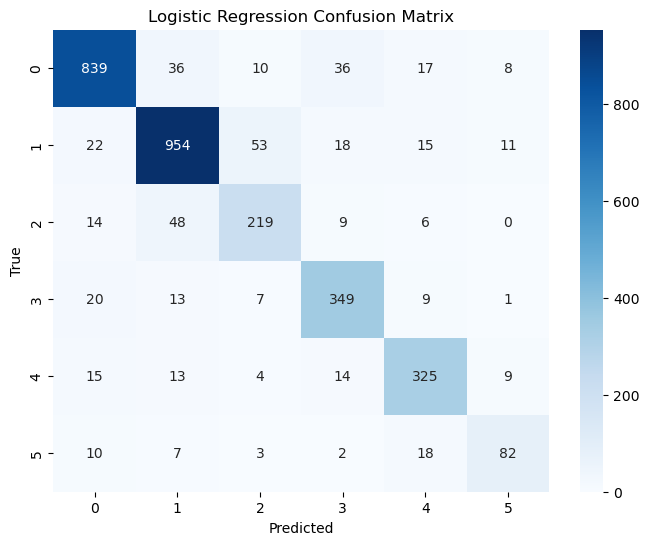

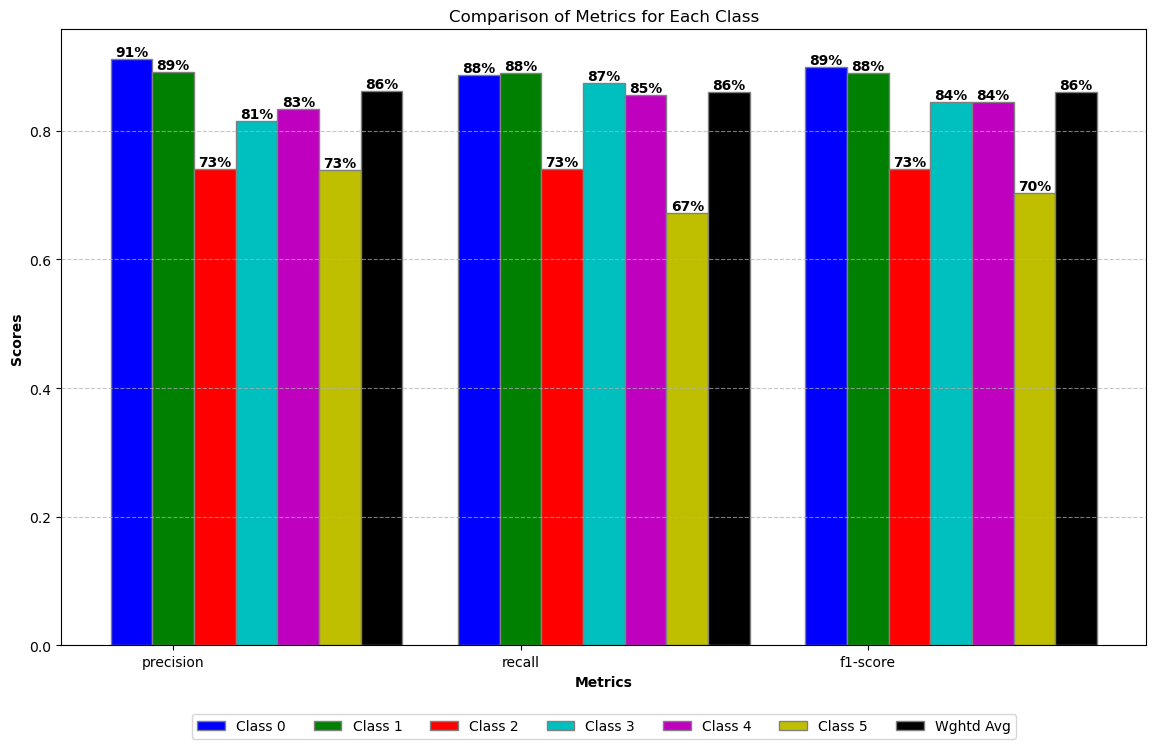


Accuracy for Logistic Regression: 86.07%



In [24]:
# Evaluation
recordmaking(model_name, model, y_pred)

The logistic regression model demonstrates strong overall performance with an accuracy of **86.07%**. It is particularly **effective in identifying sadness, joy, & anger** sentiments. However, it shows some **weaknesses in correctly identifying love and surprise** sentiments, as indicated by the lower precision scores for these classes. The balanced macro and weighted averages suggest that the model performs well across different sentiment classes, with slight room for improvement in precision for certain classes.

### Ensemble Method : XGBoosting

**XGBoost (Extreme Gradient Boosting)** is an advanced implementation of gradient boosting. It combines the predictions of multiple weak learners (decision trees) to create a strong predictive model.

It optimizes both speed and performance, making it a popular choice for many machine learning tasks.

How will we tune hyperparameters with GridSearchCV?

- Define the Parameter Grid: Specify a range of values for each hyperparameter.

- Cross-Validation: Split data into multiple folds and evaluate each parameter combination.

- Model Fitting: Train the model with the best parameters on the entire training set.

Parameter Selection:

- n_estimators: Number of boosting rounds or trees.
- learning_rate: Shrinks feature weights to prevent overfitting.
- max_depth: Maximum depth of a tree.

Further, we are using **GridSearchCV** to find the best parameters for each individual model within the ensemble. Also, we will be using **resampled data** for our training here as it seems to perform better. 

Let's begin with our modeling using XGBoosting Ensemble method 


In [25]:
model_name = "XGBoosting"

# Creating XGBoosting Classifier
rf_clf = XGBClassifier(random_state=42)

# Grid Search for XGBoost hyperparameter tuning
param_grid_rf = {'n_estimators': [200, 300], 'max_depth': [10, 20], 'learning_rate':[1, 10]}
grid_search_xgb = GridSearchCV(rf_clf, param_grid_rf, scoring='f1_weighted', cv=5)
grid_search_xgb.fit(X_resampled, y_resampled)

# Best XGBClassifier model
best_xgb_clf = grid_search_xgb.best_estimator_

# Predictions
y_pred, y_pred_prob = testingModel(model_name, best_xgb_clf)

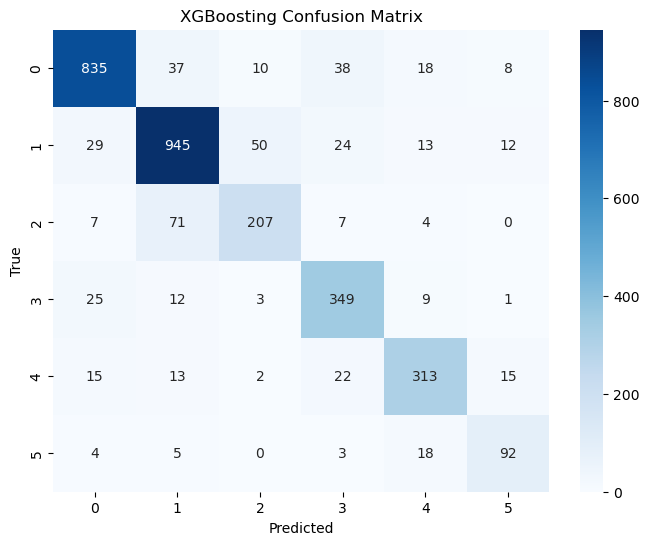

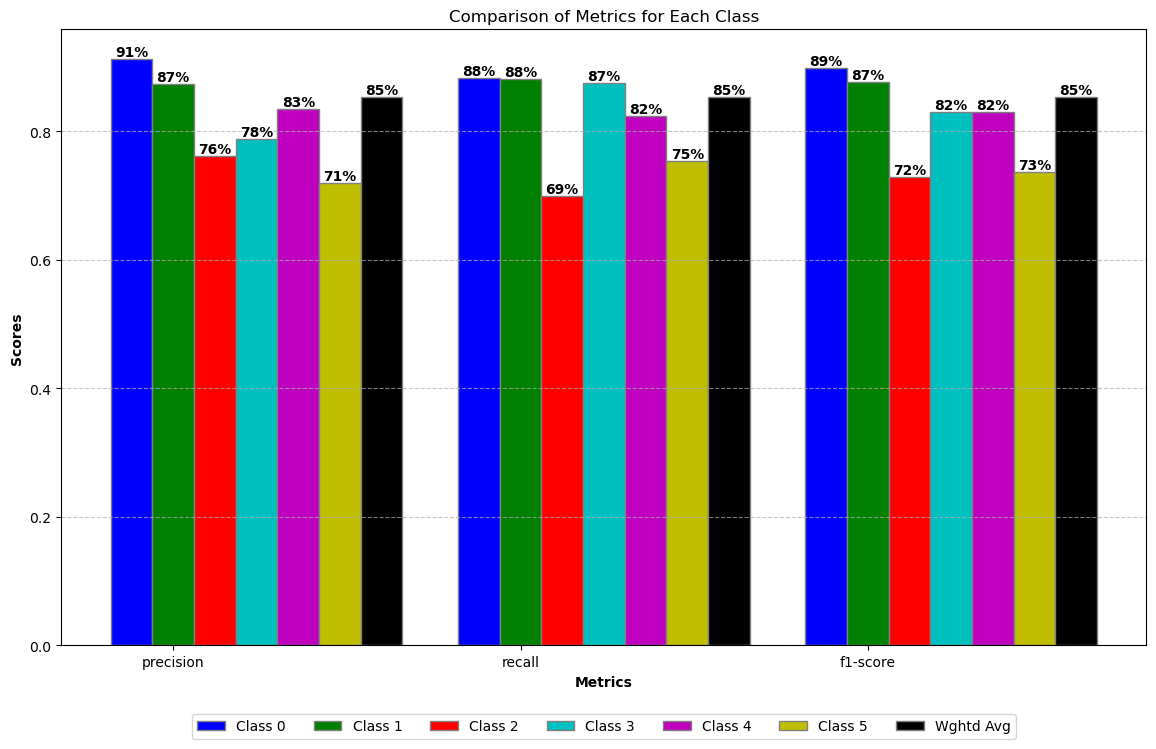


Accuracy for XGBoosting: 85.23%


Best Scores : 0.9214216113042589
Best Params : {'learning_rate': 1, 'max_depth': 10, 'n_estimators': 200}


In [26]:
# Evaluation
recordmaking(model_name, y_pred , grid_search_xgb)

### Voting Classifier : LR + SVC + Random Forest + XGBoosting

A **Voting Classifier** is an machine learning algorithm that **combines the predictions from multiple models (classifiers)** to make a final prediction. It operates on the principle of **majority voting (for classification)** or averaging (for regression).

1.Improved Performance: By combining multiple models, the Voting Classifier leverages the strengths of each model and improves overall performance.
2.Robustness: Reduces the risk of relying on a single poorly performing model and increases robustness.
3.Simplicity: Easy to implement and can quickly boost the performance of simpler models.

As we already saw **XGBoosting** performing better than **Logistic Regression** in certain areas and vice versa, we will be using their combination to eradicate the weakness of each of them. Further, **SVC** and **Random Forest** seem to be a strong classifiers while experimenting with them on the resampled data so these will also be added.

Also, we are now already aware of the hyperparameters values so we will be skipping the tuning with GridSearchCV and directly using it with our classifiers. 

Let's explore voting classifier.

In [27]:
model_name = "Voting Classifier"

# Initialize individual models
log_reg = LogisticRegression(class_weight=class_weights, solver='liblinear', multi_class='auto', random_state=42)
svm = SVC(class_weight=class_weights, probability=True, random_state=42)
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
xgb = XGBClassifier(n_estimators=200, max_depth=10, random_state=42)

# Create a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('lr', log_reg),
    ('svm', svm),
    ('rf', rf),
    ('xgb', xgb)
], voting='soft')

# Train the voting classifier
voting_clf.fit(X_resampled, y_resampled)

# Predictions
y_pred, y_pred_prob = testingModel(model_name, voting_clf)

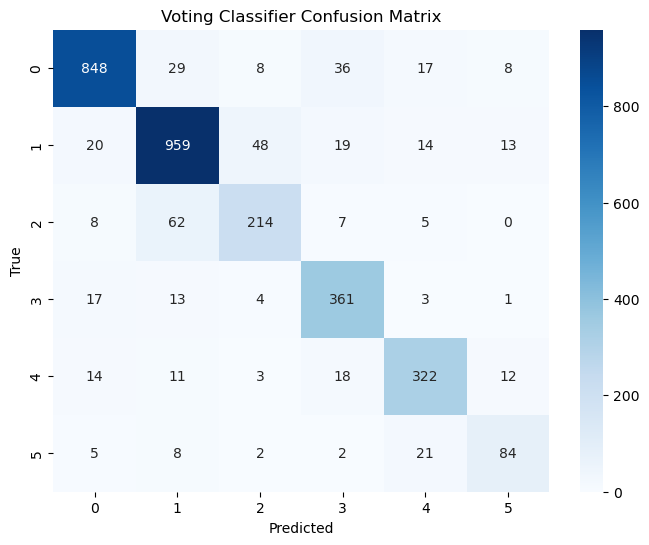

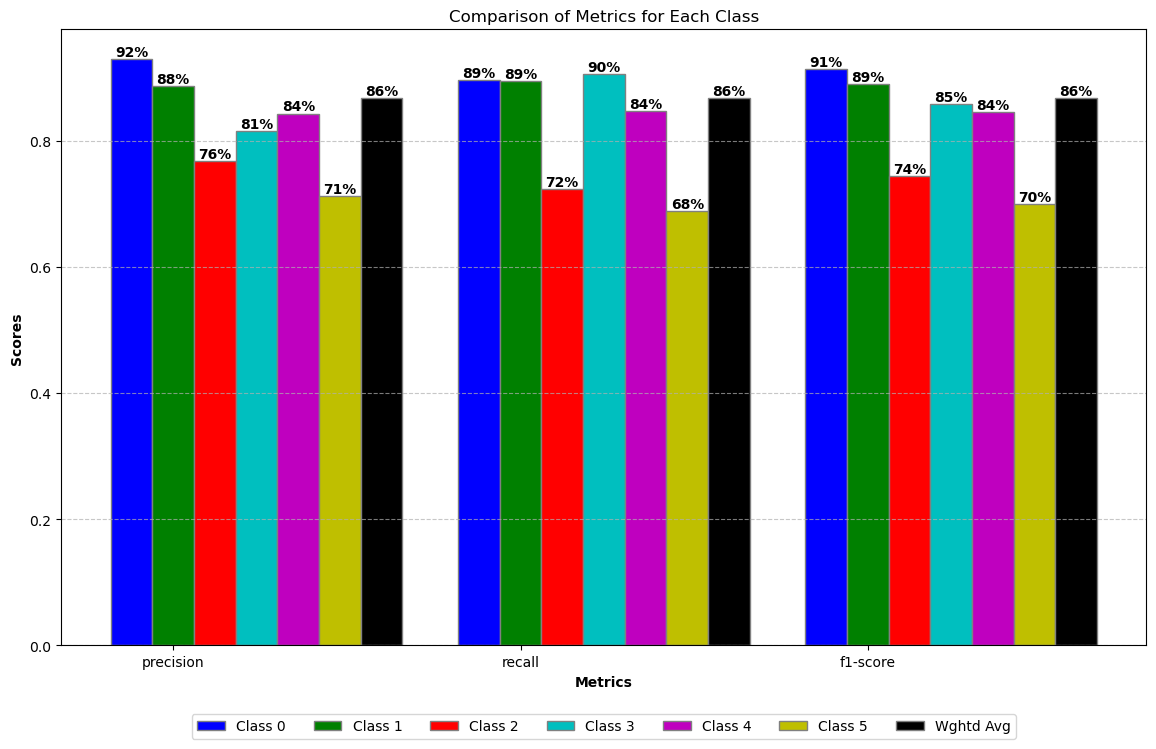


Accuracy for Voting Classifier: 86.69%



In [28]:
# Evaluation
recordmaking(model_name, y_pred)

### Stacking Classifier : LR + SVC + Random Forest + XGBoosting

A **Stacking Classifier** is an learning technique that combines multiple classification models via a **meta-classifier**. The base-level models (first layer) are trained on the original dataset, and the meta-classifier (second layer) is trained on the outputs of the base-level models.

We aim to build a robust and high-performing text classification model that benefits from the diversity and combined strengths of multiple classifiers.

Let's explore stacking classifier.

In [29]:
model_name = "Stacking Classifier"

# initialize
estimators=[
    ('lr', LogisticRegression(class_weight=class_weights, solver='liblinear', multi_class='auto', random_state=42)),
    ('svm', SVC(class_weight=class_weights, probability=True, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=200, max_depth=10, random_state=42))
]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=SVC(class_weight=class_weights, probability=True, random_state=42))
stacking_clf.fit(X_resampled, y_resampled)

# Predictions
y_pred, y_pred_prob = testingModel(model_name, stacking_clf)

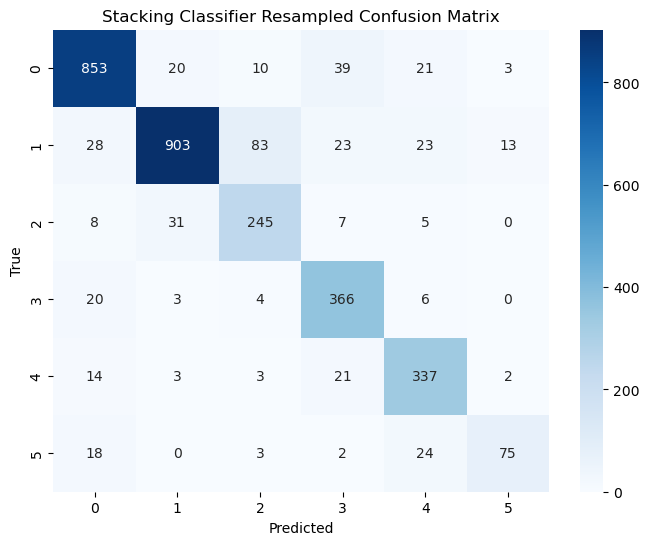

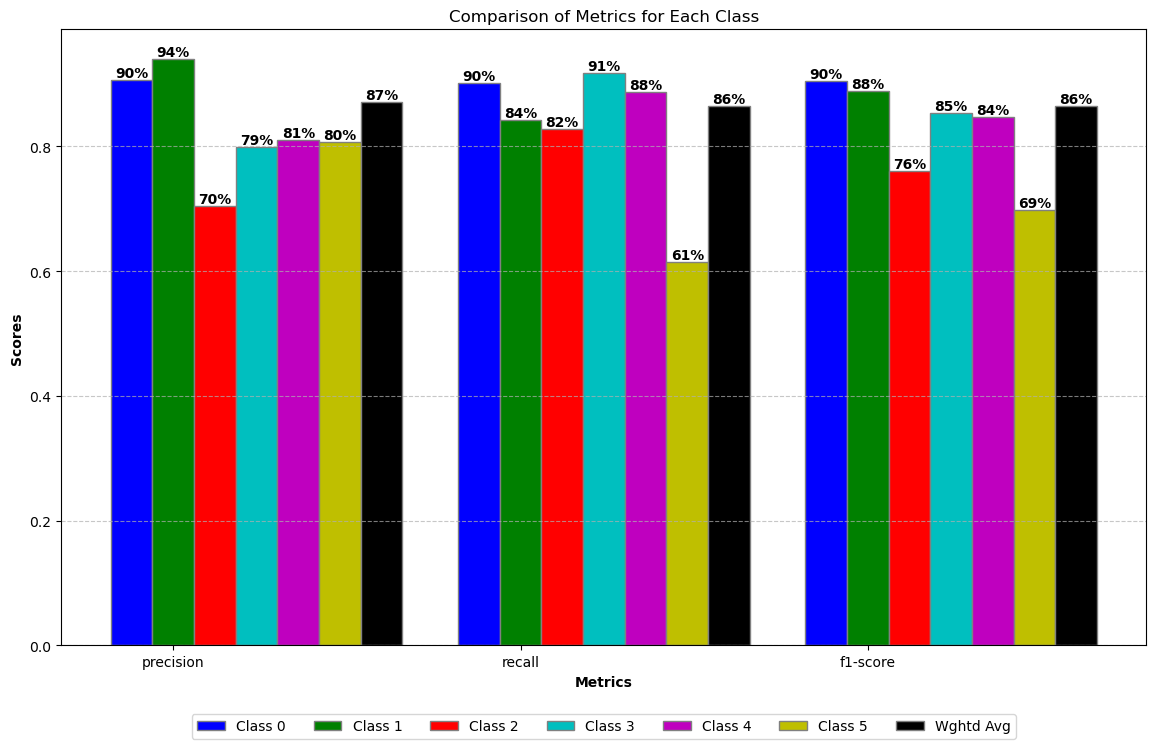


Accuracy for Stacking Classifier Resampled: 86.41%



In [30]:
# Evaluation
recordmaking(model_name, y_pred)

## Saving Models

In [39]:
# Save the model and vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
for k in record.keys():
    joblib.dump(record[k]["model"], f'{k}.pkl')

## Validation

In [46]:
#load models & perform validation with the remaining data (10%)

report = []

for mod in record.keys():
    loaded_model = joblib.load(f'{mod}.pkl')
    
    # Predictions
    y_val_pred = loaded_model.predict(X_val_tfidf)
    
    # evaluations
    accuracy = accuracy_score(y_val, y_val_pred)
    class_report = classification_report(y_val, y_val_pred, output_dict=True)
    weighted_avg = class_report['weighted avg']
    report.append([mod, accuracy, weighted_avg['precision'], weighted_avg['recall'], weighted_avg['f1-score']])
    
    # Create DataFrame for reports
    report_df = pd.DataFrame(report, columns=['Model', 'Accuracy', 'Weighted Avg Precision', 'Weighted Avg Recall', 'Weighted Avg F1-Score'])    

In [47]:
report_df.head(4)

,Model,Accuracy,Weighted Avg Precision,Weighted Avg Recall,Weighted Avg F1-Score
0,Logistic Regression,0.850379,0.850146,0.850379,0.850091
1,XGBoosting,0.866162,0.866585,0.866162,0.866086
2,Voting Classifier,0.863005,0.863344,0.863005,0.863045
3,Stacking Classifier,0.860480,0.865638,0.860480,0.861788


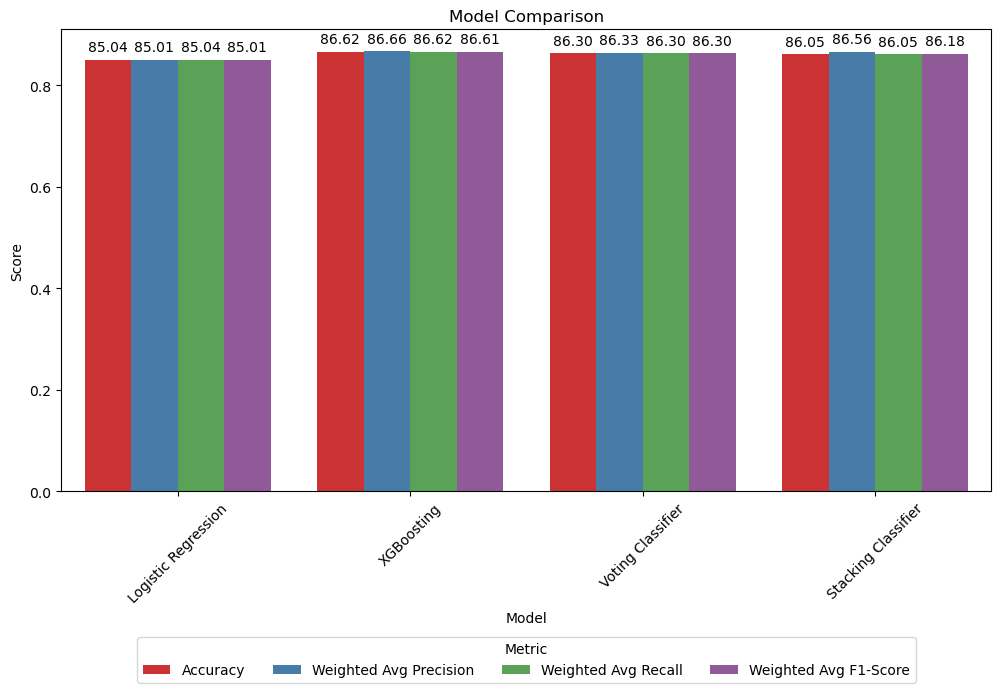

In [112]:
# Melt the DataFrame to have a long-form data suitable for seaborn
report_melted = report_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot the combined bar plot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='Model', y='Score', hue='Metric', data=report_melted, palette='Set1')

plt.title('Model Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Metric', loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=report_df.shape[0])

# Add the values on top of the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height()*100, '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')


plt.show()

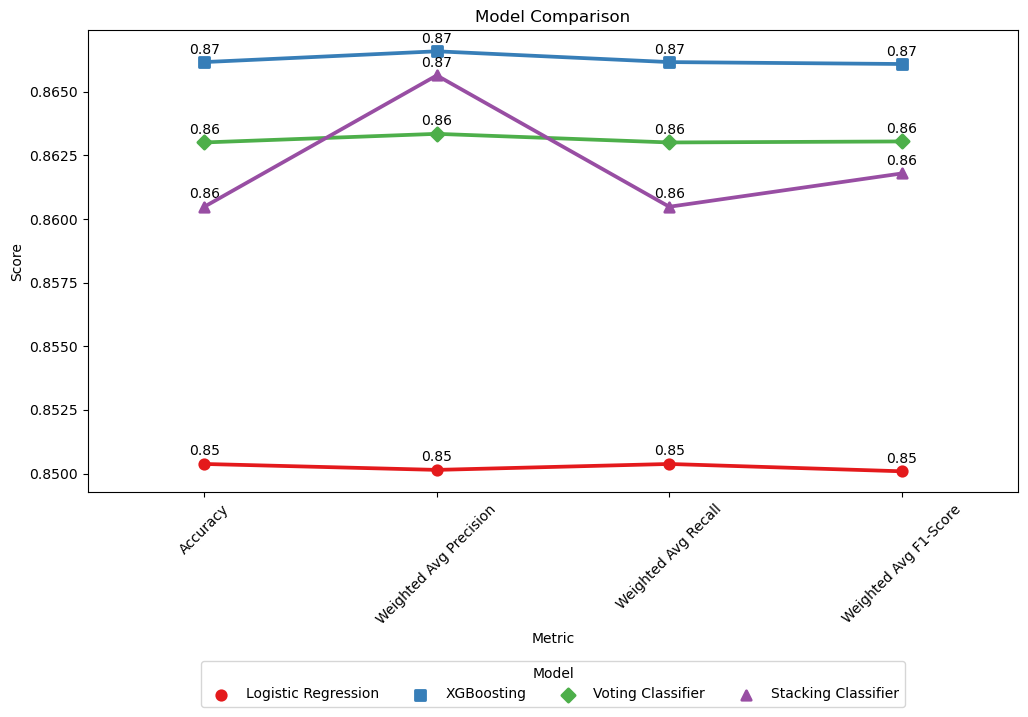

In [110]:
# Melt the DataFrame to have a long-form data suitable for seaborn
report_melted = report_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot the combined point plot
plt.figure(figsize=(12, 6))
pointplot = sns.pointplot(x='Metric', y='Score', hue='Model', data=report_melted, palette='Set1', markers=["o", "s", "D", "^"])
plt.title('Model Comparison')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.xticks(rotation=45)
plt.legend(title='Model', loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=4)

# Add the values on top of the points
for i, line in enumerate(pointplot.get_lines()):
    for j, point in enumerate(line.get_xydata()):
        pointplot.annotate(format(point[1], '.2f'), 
                           (point[0], point[1]), 
                           ha='center', va='center', 
                           xytext=(0, 9), 
                           textcoords='offset points')

plt.show()

## Conclusion

From the analysis, we can conclude that:

- XGBoosting stands out as the top performer, making it the most suitable choice for tasks requiring high accuracy and precision. Its ability to capture complex patterns in the data makes it a powerful tool for classification problems.

- The Voting Classifier also provides strong results and serves as a robust ensemble method, ensuring stability and reliability by leveraging the strengths of multiple models.

- The Stacking Classifier offers a competitive performance, especially in precision, and can be a valuable approach when the combination of different models' predictions is beneficial.

- Logistic Regression remains a solid baseline model with commendable performance, particularly when simplicity and interpretability are essential.

Overall, while all models demonstrate competent performance, XGBoosting is the most promising, followed by the Voting Classifier and the Stacking Classifier. These models provide a blend of high accuracy, precision, and stability, making them excellent choices for various classification tasks.